In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from xgboost.sklearn import XGBClassifier
pd.set_option('display.max_columns', None) # Set the option to display all columns

In [2]:
df = pd.read_csv("fraud_oracle.csv")
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [3]:
columns_to_drop = ['MonthClaimed', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 'WeekOfMonthClaimed', 'PolicyNumber', 'AgeOfPolicyHolder']
df = df.drop(columns=columns_to_drop, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   Make                  15420 non-null  object
 2   AccidentArea          15420 non-null  object
 3   Sex                   15420 non-null  object
 4   MaritalStatus         15420 non-null  object
 5   Age                   15420 non-null  int64 
 6   Fault                 15420 non-null  object
 7   PolicyType            15420 non-null  object
 8   VehicleCategory       15420 non-null  object
 9   VehiclePrice          15420 non-null  object
 10  FraudFound_P          15420 non-null  int64 
 11  RepNumber             15420 non-null  int64 
 12  Deductible            15420 non-null  int64 
 13  DriverRating          15420 non-null  int64 
 14  Days_Policy_Accident  15420 non-null  object
 15  Days_Policy_Claim     15420 non-null

## Label Encoding

- Binary categorical features: Sex, Fault, PoliceReportFiled, WitnessPresent, AgentType
- I will apply Label encoder for these variables

In [4]:
binary_columns = ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']
le = LabelEncoder()

for col  in binary_columns:
    df[col] = le.fit_transform(df[col])
    print('Label Mapping: ', dict(zip(le.classes_, le.transform(le.classes_))))

Label Mapping:  {'Rural': np.int64(0), 'Urban': np.int64(1)}
Label Mapping:  {'Female': np.int64(0), 'Male': np.int64(1)}
Label Mapping:  {'Policy Holder': np.int64(0), 'Third Party': np.int64(1)}
Label Mapping:  {'No': np.int64(0), 'Yes': np.int64(1)}
Label Mapping:  {'No': np.int64(0), 'Yes': np.int64(1)}
Label Mapping:  {'External': np.int64(0), 'Internal': np.int64(1)}


In [5]:
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

vehicleprice_mapping = {
    'less than 20000': 0, '20000 to 29000': 1, '30000 to 39000': 2,
    '40000 to 59000': 3, '60000 to 69000': 4, 'more than 69000': 5
}

ageofvehicle_mapping = {
    'new': 2, '2 years': 0, '3 years': 2, '4 years': 2,
    '5 years': 1, '6 years': 1, '7 years': 0, 'more than 7': 0
} # 3 classes detected during the EDA

basepolicy_mapping = {'Liability': 0, 'Collision': 1, 'All Perils': 2}

materialstatus_mapping = {'Single': 0, 'Married': 1, 'Widow': 2, 'Divorced': 3}

policy_type_mapping = {
    'Sport - Liability': 0,
    'Sport - Collision': 1,
    'Sport - All Perils': 2,
    'Sedan - Liability': 3,
    'Sedan - Collision': 4,
    'Sedan - All Perils': 5,
    'Utility - Liability': 6,
    'Utility - Collision': 7,
    'Utility - All Perils': 8
}

vehicle_category_mapping = {
    'Sport': 0,
    'Sedan': 1,
    'Utility': 2
}

days_policy_accident_mapping = {
    'none': 0,
    '1 to 7': 1,
    '8 to 15': 2,
    '15 to 30': 3,
    'more than 30': 4
}

days_policy_claim_mapping = {
    'none': 0,
    '8 to 15': 1,
    '15 to 30': 2,
    'more than 30': 3
}

past_number_of_claims_mapping = {
    'none': 0,
    '1': 1,
    '2 to 4': 2,
    'more than 4': 3
}


number_of_suppliments_mapping = {
    'none': 0,
    '1 to 2': 1,
    '3 to 5': 2,
    'more than 5': 3
}

address_change_claim_mapping = {
    'no change': 0,
    'under 6 months': 1,
    '1 year': 2,
    '2 to 3 years': 3,
    '4 to 8 years': 4
}

number_of_cars_mapping = {
    '1 vehicle': 0,
    '2 vehicles': 1,
    '3 to 4': 2,
    '5 to 8': 3,
    'more than 8': 4
}
    
# Encoding categorical variables
df['Month'] = df['Month'].map(month_mapping)
df['VehiclePrice'] = df['VehiclePrice'].map(vehicleprice_mapping)
df['AgeOfVehicle'] = df['AgeOfVehicle'].map(ageofvehicle_mapping)
df['BasePolicy'] = df['BasePolicy'].map(basepolicy_mapping)
df['MaritalStatus'] = df['MaritalStatus'].map(materialstatus_mapping)
df['Days_Policy_Accident'] = df['Days_Policy_Accident'].map(days_policy_accident_mapping)
df['Days_Policy_Claim'] = df['Days_Policy_Claim'].map(days_policy_claim_mapping)
df['PastNumberOfClaims'] = df['PastNumberOfClaims'].map(past_number_of_claims_mapping)
df['NumberOfSuppliments'] = df['NumberOfSuppliments'].map(number_of_suppliments_mapping)
df['AddressChange_Claim'] = df['AddressChange_Claim'].map(address_change_claim_mapping)
df['NumberOfCars'] = df['NumberOfCars'].map(number_of_cars_mapping)
df['PolicyType'] = df['PolicyType'].map(policy_type_mapping)
df['VehicleCategory'] = df['VehicleCategory'].map(vehicle_category_mapping)

In [6]:
df.head()

,Month,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,12,Honda,1,0,0,21,0,0,0,5,0,12,300,1,4,3,0,2,0,0,0,0,2,2,1994,0
1,1,Honda,1,1,0,34,0,1,0,5,0,15,400,4,4,3,0,1,1,0,0,0,0,0,1994,1
2,10,Honda,1,1,1,47,0,1,0,5,0,7,400,3,4,3,1,0,0,0,0,0,0,0,1994,1
3,6,Toyota,0,1,1,65,1,3,0,1,0,4,400,2,4,3,1,0,1,0,0,3,0,0,1994,0
4,1,Honda,1,0,0,27,1,1,0,5,0,3,400,1,4,3,0,1,0,0,0,0,0,0,1994,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  int64 
 1   Make                  15420 non-null  object
 2   AccidentArea          15420 non-null  int64 
 3   Sex                   15420 non-null  int64 
 4   MaritalStatus         15420 non-null  int64 
 5   Age                   15420 non-null  int64 
 6   Fault                 15420 non-null  int64 
 7   PolicyType            15420 non-null  int64 
 8   VehicleCategory       15420 non-null  int64 
 9   VehiclePrice          15420 non-null  int64 
 10  FraudFound_P          15420 non-null  int64 
 11  RepNumber             15420 non-null  int64 
 12  Deductible            15420 non-null  int64 
 13  DriverRating          15420 non-null  int64 
 14  Days_Policy_Accident  15420 non-null  int64 
 15  Days_Policy_Claim     15420 non-null

In [8]:
# Get the names of the categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Print the unique values of each categorical column
for col in categorical_columns:
    print(f"Unique values in '{col}':")
    print(df[col].unique())
    print("\n")

Unique values in 'Make':
['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']




## One Hot Encoder

In [9]:
df["Make"] = df["Make"].astype(str)
df = pd.get_dummies(df, columns=["Make"])
df.shape

(15420, 44)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Month                 15420 non-null  int64
 1   AccidentArea          15420 non-null  int64
 2   Sex                   15420 non-null  int64
 3   MaritalStatus         15420 non-null  int64
 4   Age                   15420 non-null  int64
 5   Fault                 15420 non-null  int64
 6   PolicyType            15420 non-null  int64
 7   VehicleCategory       15420 non-null  int64
 8   VehiclePrice          15420 non-null  int64
 9   FraudFound_P          15420 non-null  int64
 10  RepNumber             15420 non-null  int64
 11  Deductible            15420 non-null  int64
 12  DriverRating          15420 non-null  int64
 13  Days_Policy_Accident  15420 non-null  int64
 14  Days_Policy_Claim     15420 non-null  int64
 15  PastNumberOfClaims    15420 non-null  int64
 16  AgeO

## Removing the constant features that was encoded

In [11]:
onehot_encoded_columns = [col for col in df.columns if '_' in col]
constant_features = []
for col in onehot_encoded_columns:
    if df[col].sum() <= 6:
        constant_features.append(col)
print("The Number of Constant Features: ", len(constant_features))

The Number of Constant Features:  5


In [12]:
constant_features

['Make_Ferrari', 'Make_Jaguar', 'Make_Lexus', 'Make_Mecedes', 'Make_Porche']

In [13]:
df.drop(columns=constant_features, axis=1, inplace=True)
df.shape

(15420, 39)

## Checking the linear correlation

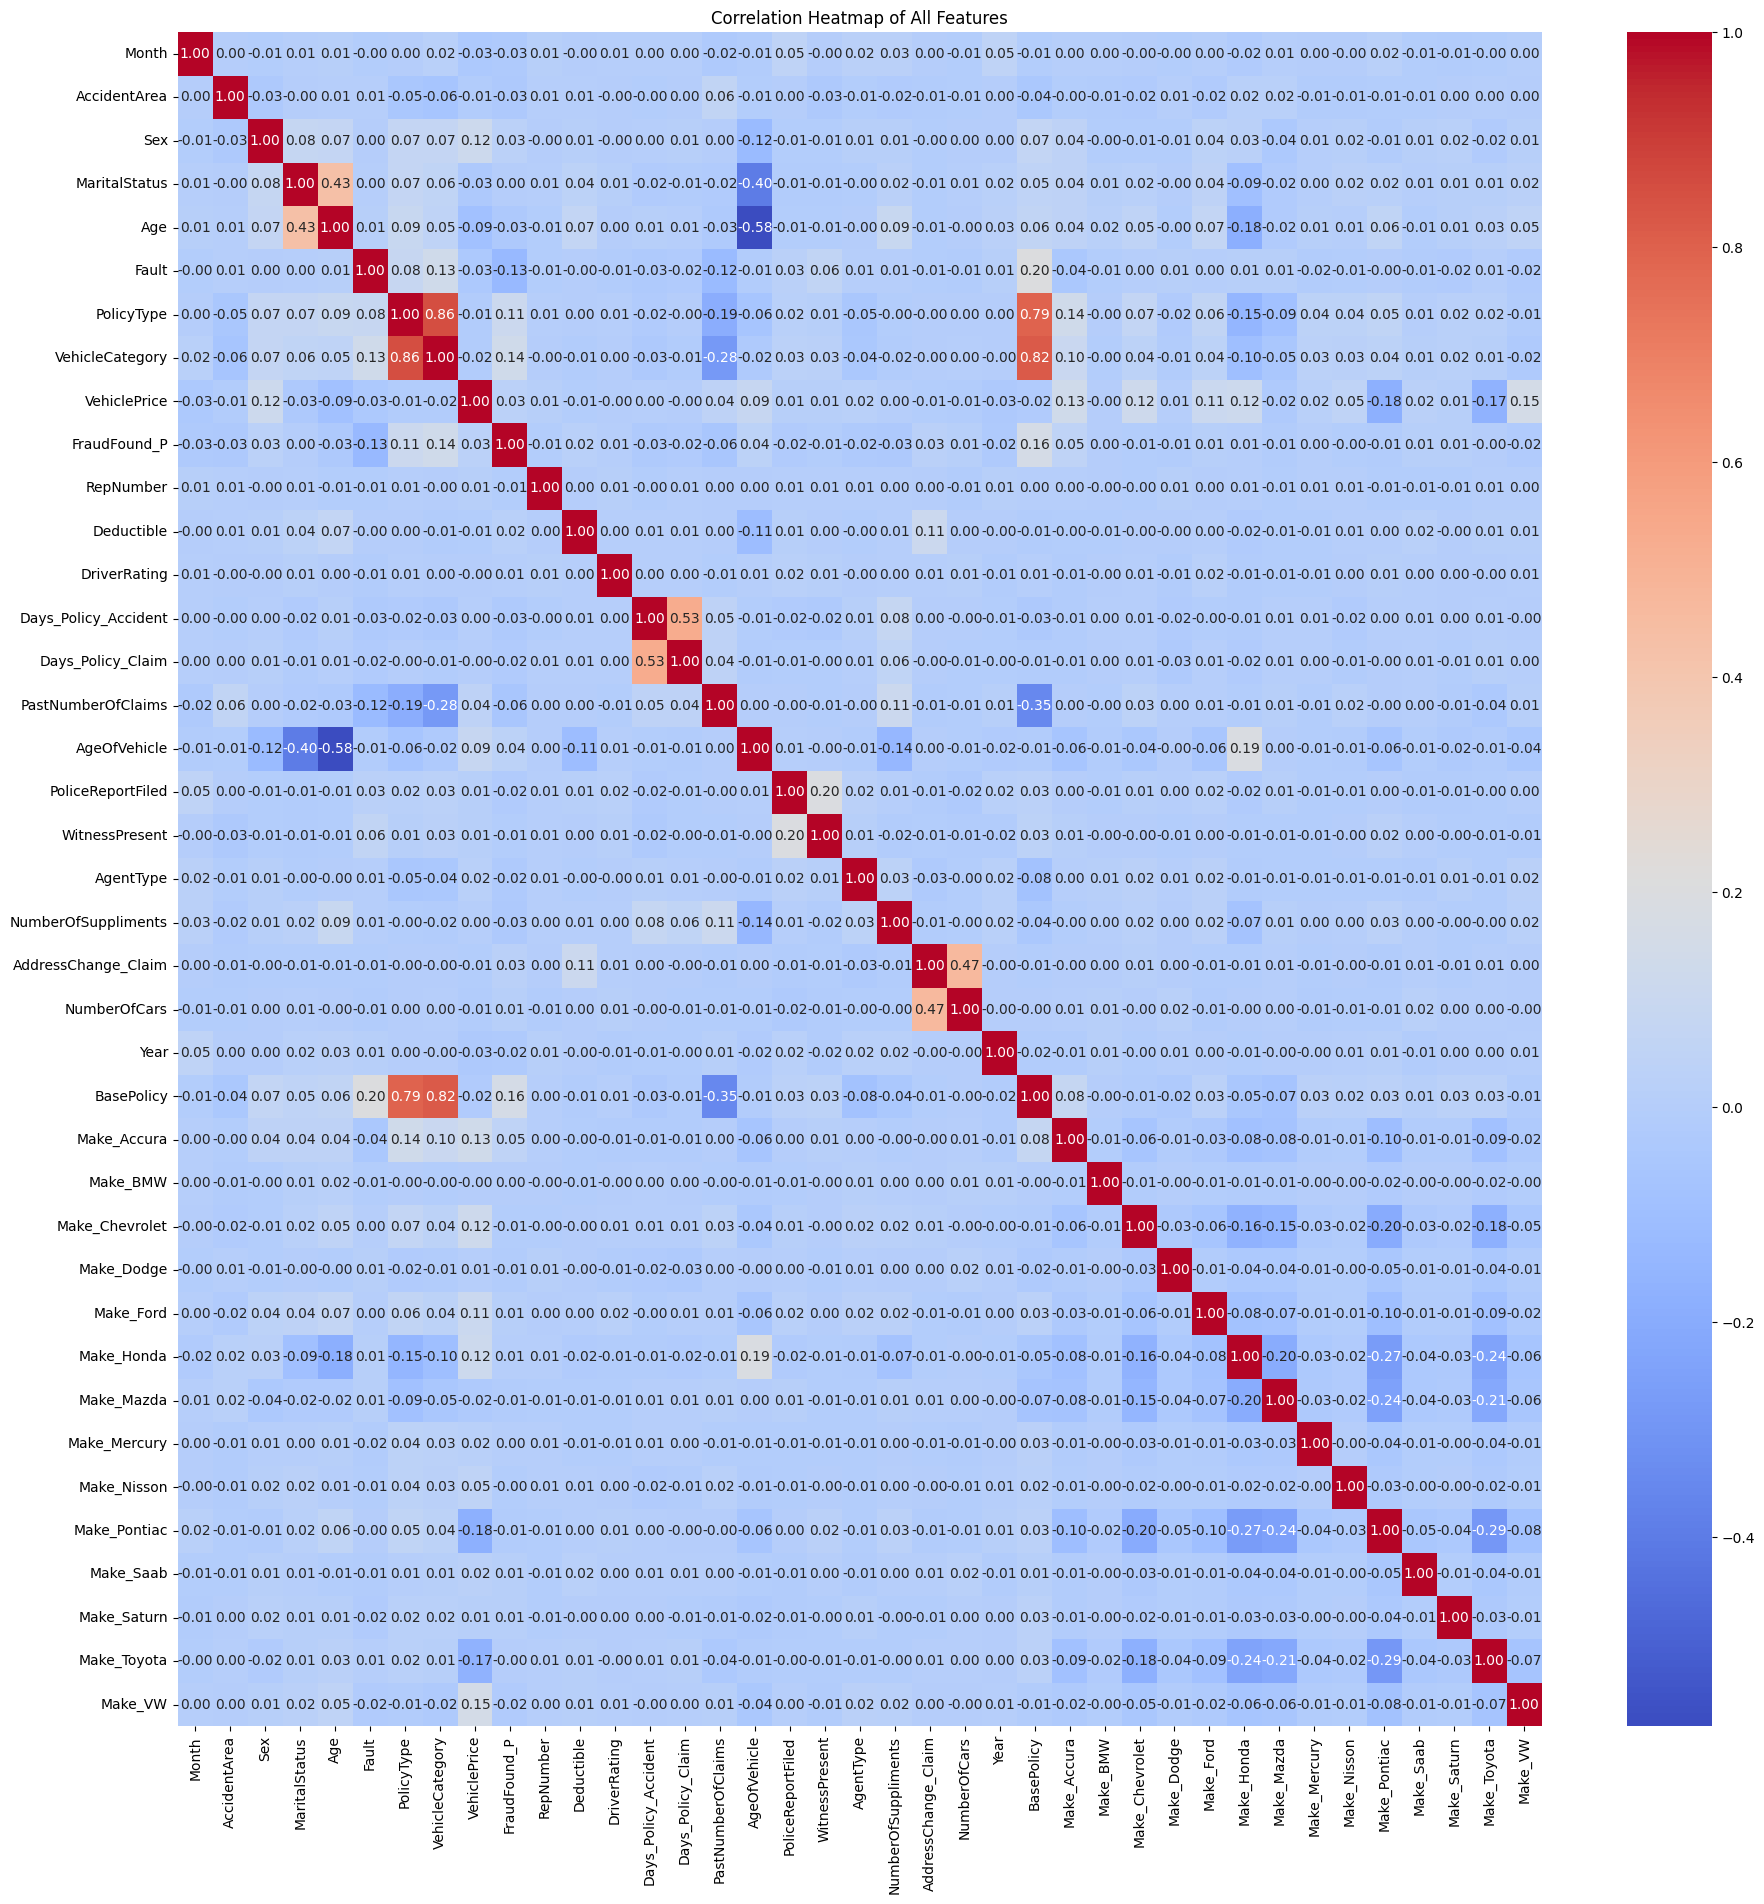

In [14]:
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(22, 22))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of All Features')
plt.show()

## Dropping the the features with high linear correlation

In [15]:
columns_to_drop2 = ["PolicyType"]
df.drop(columns_to_drop2, axis = 1, inplace = True)

## Imputation of the Feature Age with the median

In [16]:
df.Age.value_counts().reset_index().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
Age,30,33,34,35,28,29,31,32,27,26,39,41,44,37,36,43,42,45,38,40,0,47,46,48,50,54,55,51,52,49,53,60,64,56,61,57,59,63,65,24,58,21,22,23,62,25,18,72,66,76,71,74,78,75,19,68,73,69,80,67,77,20,70,79,16,17
count,596,574,573,569,560,552,550,544,540,535,435,423,411,410,406,404,401,386,384,383,320,308,296,291,290,288,282,279,276,265,253,156,146,146,145,144,138,136,135,135,134,127,125,122,112,104,48,45,42,42,40,35,35,34,32,32,32,32,32,31,29,28,27,20,9,6


- We have 320/15420 case with Age = 0

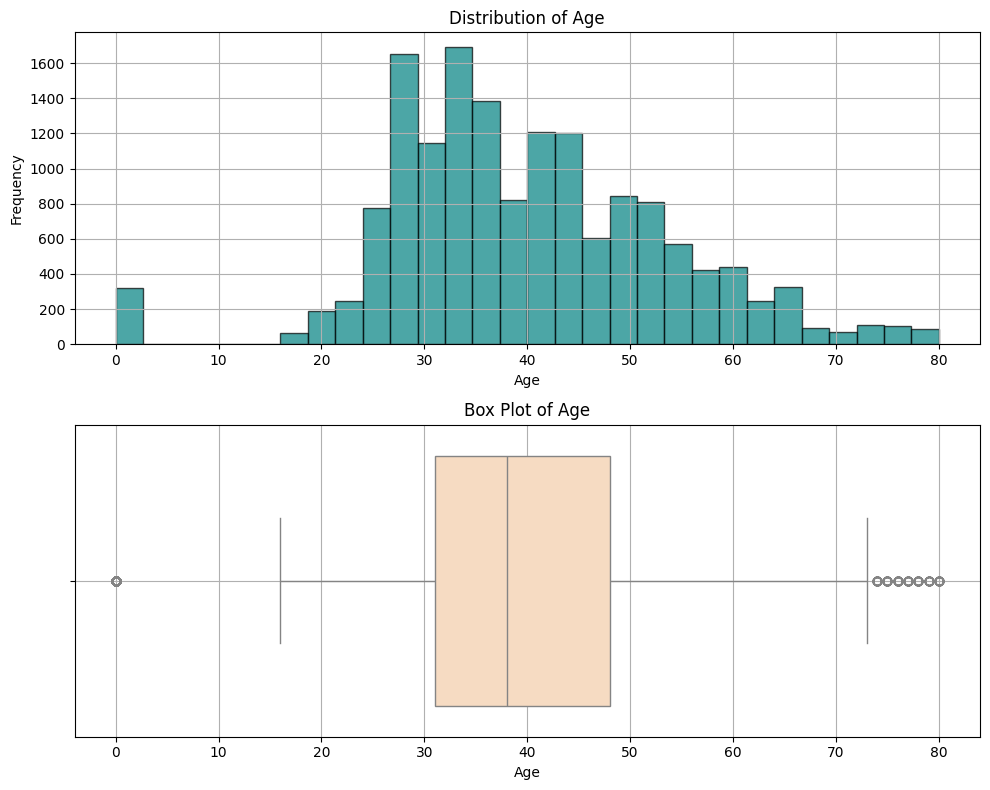

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Histogram of Age
df['Age'].plot(kind='hist', bins=30, alpha=0.7, ax=axes[0], edgecolor='black', color= 'teal')
axes[0].set_title('Distribution of Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].grid()

# Box Plot of Age
sns.boxplot(x='Age', data=df, ax=axes[1], color='#FFDAB9')
axes[1].set_title('Box Plot of Age')
axes[1].set_xlabel('Age')
axes[1].grid()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [18]:
# Calculate the median of the 'age' column
age_median = df['Age'].median().astype(int)
age_median

np.int64(38)

In [19]:
df['Age'].replace(0, age_median, inplace = True)

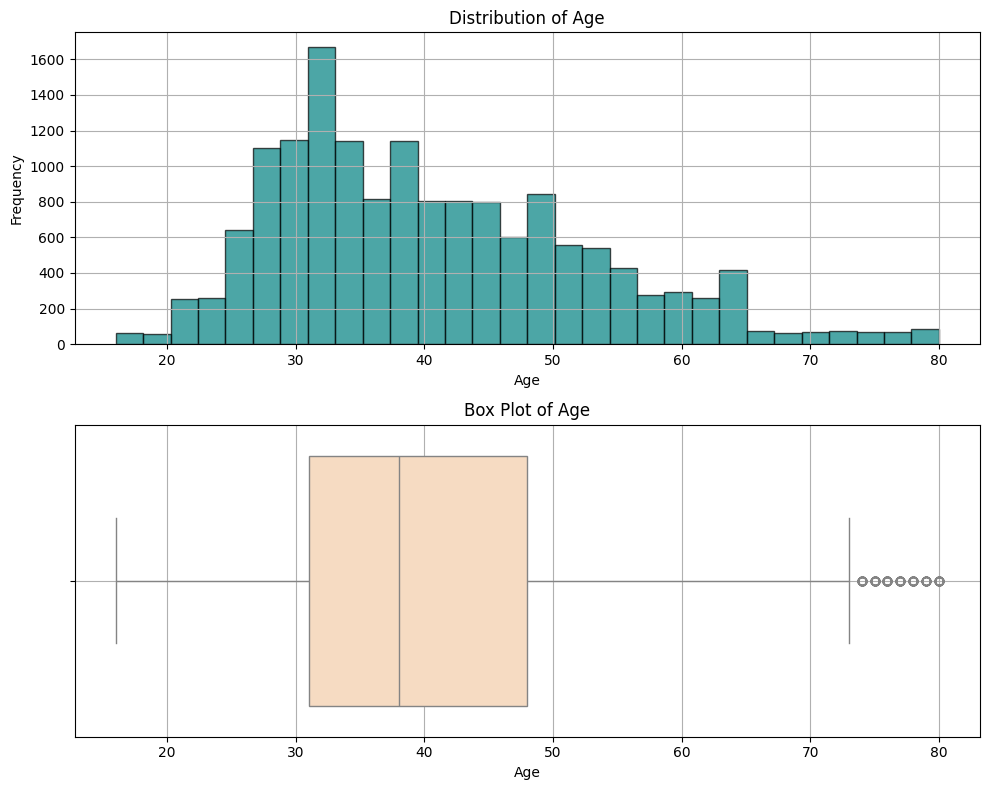

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Histogram of Age
df['Age'].plot(kind='hist', bins=30, alpha=0.7, ax=axes[0], edgecolor='black', color= 'teal')
axes[0].set_title('Distribution of Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].grid()

# Box Plot of Age
sns.boxplot(x='Age', data=df, ax=axes[1], color='#FFDAB9')
axes[1].set_title('Box Plot of Age')
axes[1].set_xlabel('Age')
axes[1].grid()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [21]:
age_dataset = df.Age.value_counts().reset_index()
age_dataset[age_dataset["Age"] > 72]['count'].sum()

np.int64(259)

- We have 259/15420 outlier

## Distribution of Driver Rating by the Age

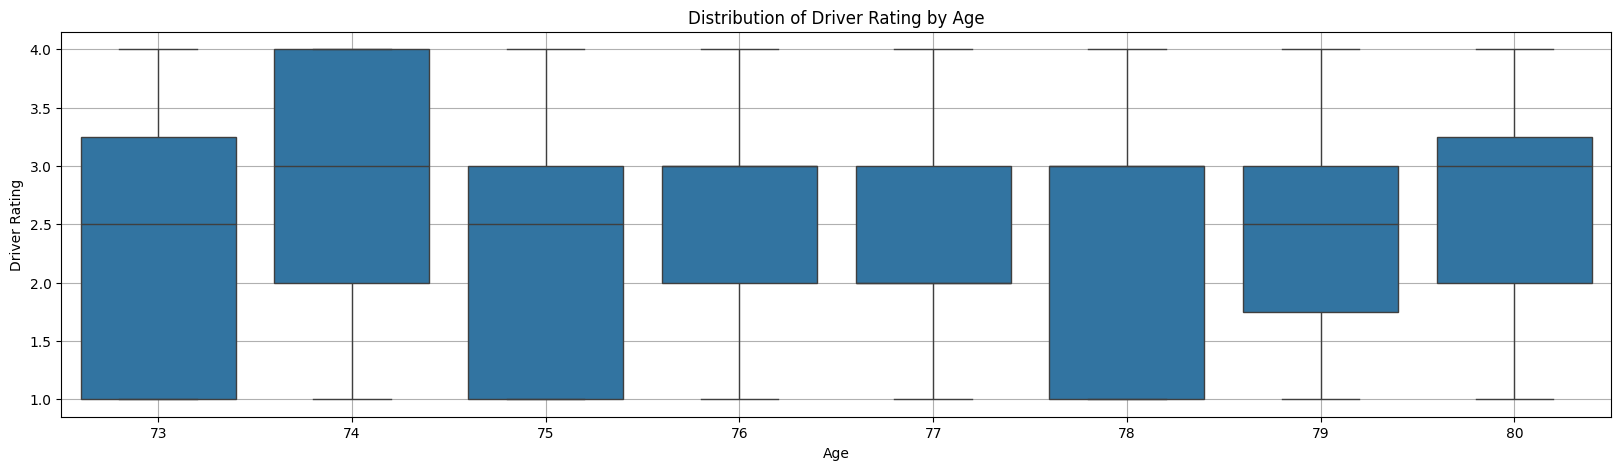

In [22]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='Age', y='DriverRating', data=df[df["Age"] > 72])
plt.xlabel('Age')
plt.ylabel('Driver Rating')
plt.title('Distribution of Driver Rating by Age')
plt.grid()
plt.show()

- There’s no obvious correlation between Driver Rating and Driver Age that indicates eligibility to drive a car

- Boosting models can perform well on imbalanced data, but for the rest of the models the data has to be balanced
- We will create a function to balance the data using SMOTE

## Train test split

In [23]:
def train_test_split_func(df, test_size_param, random_state, target_column = 'FraudFound_P'):
    # Extract features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_param, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = train_test_split_func(df, 0.2, 0)

## SMOTE oversampling to balance the data

In [25]:
def smote_oversampling(X_train, y_train, random_state=0):
    # applies SMOTE oversampling technique on train data with a given random state

    smote = SMOTE(random_state=random_state)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Display information before and after applying SMOTE
    print("Taining data before SMOTE: ", X_train.shape, y_train.shape)
    print("Training data after SMOTE: ", X_train_smote.shape, y_train_smote.shape)
    print()
    print("After SMOTE Label Distribution: ", pd.Series(y_train_smote).value_counts())

    # Create a DataFrame of the SMOTE-resampled training data
    df_smote_train = pd.concat([X_train_smote, y_train_smote], axis=1)
    print("Resampled DataFrame shape: ", df_smote_train.shape)

    return df_smote_train

In [26]:
df_smote = smote_oversampling(X_train, y_train)
df_smote

Taining data before SMOTE:  (12336, 37) (12336,)
Training data after SMOTE:  (23190, 37) (23190,)

After SMOTE Label Distribution:  FraudFound_P
0    11595
1    11595
Name: count, dtype: int64
Resampled DataFrame shape:  (23190, 38)


,Month,AccidentArea,Sex,MaritalStatus,Age,Fault,VehicleCategory,VehiclePrice,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,Make_Accura,Make_BMW,Make_Chevrolet,Make_Dodge,Make_Ford,Make_Honda,Make_Mazda,Make_Mercury,Make_Nisson,Make_Pontiac,Make_Saab,Make_Saturn,Make_Toyota,Make_VW,FraudFound_P
0,12,1,1,1,50,0,1,2,10,400,1,4,3,0,0,0,0,0,3,4,1,1994,1,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0
1,4,1,1,0,27,0,1,2,12,400,3,4,3,2,0,0,0,0,2,0,0,1995,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0
2,3,1,1,1,37,1,1,1,5,400,4,4,3,0,0,0,0,0,3,0,0,1995,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0
3,12,1,1,1,55,0,0,2,15,400,1,2,1,1,0,0,0,0,0,0,0,1994,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,0
4,12,1,0,1,34,0,0,5,14,400,1,4,3,2,1,0,0,0,1,0,0,1994,0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23185,6,0,1,0,20,0,0,2,5,400,2,4,3,2,2,0,0,0,2,0,0,1994,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,1
23186,5,1,1,0,30,0,1,0,13,400,3,4,3,0,0,0,0,0,0,0,0,1994,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1
23187,9,0,1,1,29,0,1,5,12,400,2,4,3,0,0,0,0,0,0,0,0,1995,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1
23188,3,1,1,0,37,0,1,5,12,400,1,4,3,0,1,0,0,0,0,0,0,1994,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1


In [27]:
(pd.DataFrame(y_test))['FraudFound_P'].value_counts()

FraudFound_P
0    2902
1     182
Name: count, dtype: int64

## Feature Selection

### Variance Threshold (it is a filter method in feature selection)

In [28]:
X_train_smote = df_smote.drop(columns="FraudFound_P")
y_train_smote = df_smote["FraudFound_P"]
# VarianceThreshold
selector = VarianceThreshold(threshold=0.01) # The larger the threshold, the more features are eliminated.
X_train_reduced_v1 = selector.fit_transform(X_train_smote)
print(X_train_smote.shape, y_train_smote.shape)
print(X_train_reduced_v1.shape)


(23190, 37) (23190,)
(23190, 28)


In [29]:
dropped_columns_v1 = X_train_smote.columns[~selector.get_support()]
dropped_columns_v1

Index(['WitnessPresent', 'AgentType', 'Make_BMW', 'Make_Dodge', 'Make_Mercury',
       'Make_Nisson', 'Make_Saab', 'Make_Saturn', 'Make_VW'],
      dtype='object')

In [30]:
df_smote[dropped_columns_v1.tolist()].var().reset_index()

,index,0
0,WitnessPresent,0.003138
1,AgentType,0.007787
2,Make_BMW,0.000431
3,Make_Dodge,0.003823
4,Make_Mercury,0.002667
5,Make_Nisson,0.001077
6,Make_Saab,0.003695
7,Make_Saturn,0.002109
8,Make_VW,0.009651


## RFECV
- I'll be using it after modeling

In [31]:
xgb_model = XGBClassifier(n_jobs=-1, use_label_encoder=False)
rfecv = RFECV(estimator=xgb_model, step=1, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_train_smote, y_train_smote)
optimal_num_features =rfecv.n_features_
print(f"Optimal number of features: {optimal_num_features}")    

c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:06:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:06:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Yassine\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:06:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder"

Optimal number of features: 34


In [32]:
dropped_features = X_train_smote.columns[~rfecv.support_]

print("Features that will be dropped:", dropped_features.tolist())

Features that will be dropped: ['Days_Policy_Claim', 'WitnessPresent', 'AgentType']


- lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
- Features that will be dropped: ['Days_Policy_Claim', 'WitnessPresent', 'Make_BMW']
------------------------------------------------------------------------------------
- lightgbm_model = lgb.LGBMClassifier(n_estimators=50, learning_rate=0.1, verbose=-1)
- Features that will be dropped: ['Days_Policy_Accident', 'Days_Policy_Claim', 'WitnessPresent', 'Make_BMW']
------------------------------------------------------------------------------------
- lightgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.01, verbose=-1)
- Features that will be dropped: ['Days_Policy_Accident', 'Days_Policy_Claim', 'AgeOfVehicle', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfCars']
------------------------------------------------------------------------------------
- xgb_model = XGBClassifier(n_jobs=-1, use_label_encoder=False)
- Features that will be dropped: ['Days_Policy_Claim', 'WitnessPresent', 'AgentType']

## Dividing the dataset into 2 folds

In [51]:
def stratified_split_2_folds(df, target_column = "FraudFound_P"):
    #Splits the data into 2 parts using stratified splitting to maintain the same class distribution.

        # Extract features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Initialize StratifiedKFold with 2 splits
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
    
    # Get the indices for the split
    for idx1, idx2 in skf.split(X, y):
        df1 = df.iloc[idx1].reset_index(drop=True)
        df2 = df.iloc[idx2].reset_index(drop=True)
    return df1, df2

In [52]:
df1, df2 = stratified_split_2_folds(df)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7710 entries, 0 to 7709
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Month                 7710 non-null   int64
 1   AccidentArea          7710 non-null   int64
 2   Sex                   7710 non-null   int64
 3   MaritalStatus         7710 non-null   int64
 4   Age                   7710 non-null   int64
 5   Fault                 7710 non-null   int64
 6   VehicleCategory       7710 non-null   int64
 7   VehiclePrice          7710 non-null   int64
 8   FraudFound_P          7710 non-null   int64
 9   RepNumber             7710 non-null   int64
 10  Deductible            7710 non-null   int64
 11  DriverRating          7710 non-null   int64
 12  Days_Policy_Accident  7710 non-null   int64
 13  Days_Policy_Claim     7710 non-null   int64
 14  PastNumberOfClaims    7710 non-null   int64
 15  AgeOfVehicle          7710 non-null   int64
 16  Police